# Рекомендация тарифов



**Цель:** выявление особенностей поведения клиентов мобильной сети "Мегалайн"

**Задача:** построить систему, помогающую проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра». Необходимо построить модель для задачи классификации, которая выберет подходящий тариф.

В распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. 


## Описание данных

Данные не требуют предобработки, они были очищены и обработаны ранее. Но основные параметры будут проверены. 

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

сalls — количество звонков,

minutes — суммарная длительность звонков в минутах,

messages — количество sms-сообщений,

mb_used — израсходованный интернет-трафик в Мб,

is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).



## Знакомство с данными

In [72]:
#импортируем нужные библиотеки для работы
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings

import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import classification_report


In [73]:
#откроем файл
data = pd.read_csv('/datasets/users_behavior.csv', sep = ',')
data.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [74]:
#получим общую информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


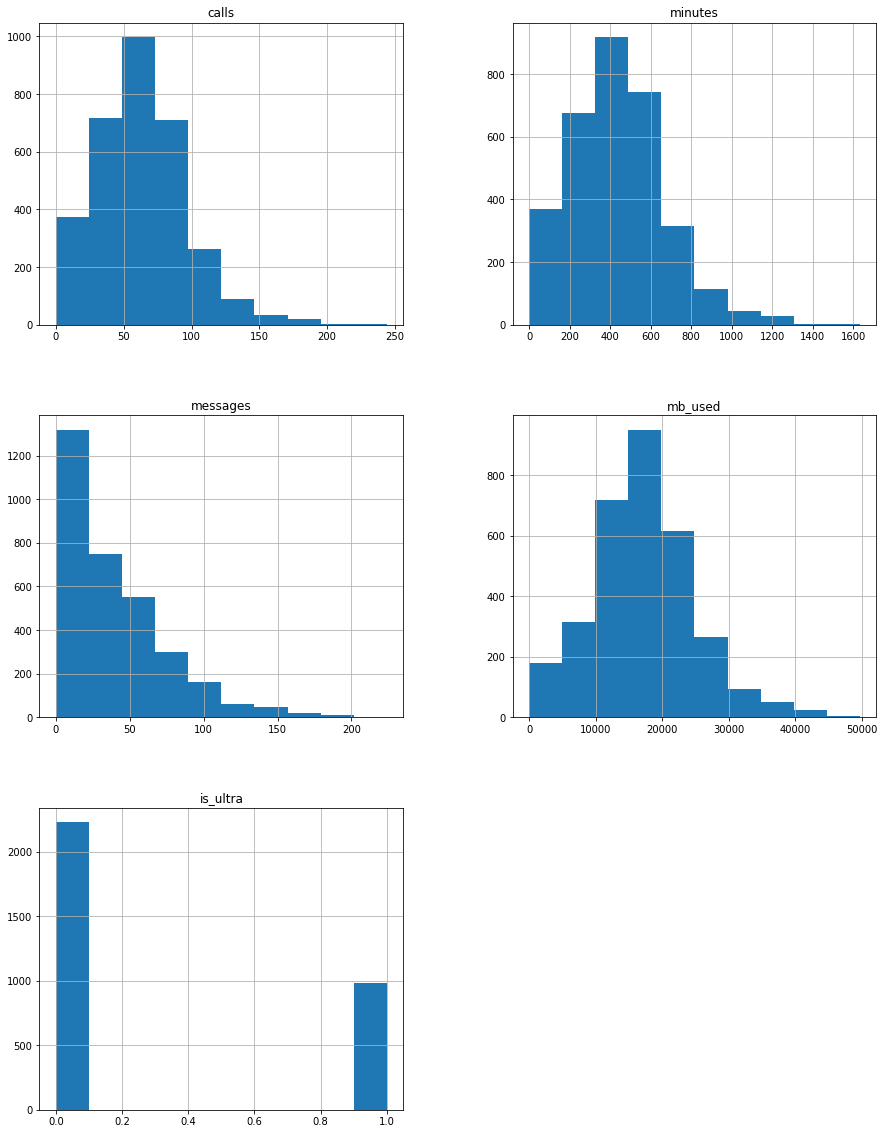

In [75]:
#получим гистограммы по всем столбцам
data.hist(figsize=(15, 20))
plt.show()

In [76]:
#проверим на явные дубликаты
data.duplicated().sum()

0

In [77]:
print(data[data['is_ultra'] == 1]['is_ultra'].count()) #посчитаем количество тарифов ультра
print(data[data['is_ultra'] == 0]['is_ultra'].count()) #посчитаем количество остальных тарифов 

985
2229


Видно, что тарифа ультра меньше в 2 с лишним раза. Тогда в дальнейшем следует оценивать точность определения конкретных тарифов, а не только общую точность.

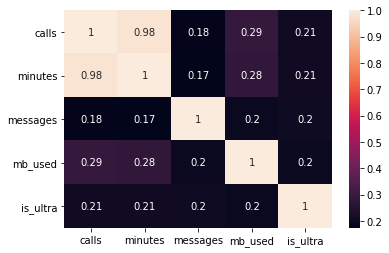

In [78]:
sns.heatmap(data.corr(), annot = True) #посмотрим корреляции Пирсона
plt.show()

С данными всё норм, гистограммы правдоподобны, датасет чистый, разницу в количестве в классах увидели. Работаем дальше

## Разделение выборок

Разделим дату на тренировочную, валидационную и тестовую выборку

In [79]:
data_train, data_test = train_test_split(data, test_size=0.25, random_state=12345, stratify=data['is_ultra'])

features = data_train.drop(['is_ultra'],axis=1)
target = data_train['is_ultra'] #целевой признак

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345, stratify=target)

features_test = data_test.drop(['is_ultra'],axis=1)
target_test = data_test['is_ultra'] #целевой признак


In [80]:
print(data_train[data_train['is_ultra'] == 1]['is_ultra'].count()) #посчитаем количество тарифов ультра
print(data_train[data_train['is_ultra'] == 0]['is_ultra'].count()) #посчитаем количество тарифов ультра
print(data_test[data_test['is_ultra'] == 1]['is_ultra'].count()) #посчитаем количество остальных тарифов 
print(data_test[data_test['is_ultra'] == 0]['is_ultra'].count()) #посчитаем количество остальных тарифов 



739
1671
246
558


## Классификация деревом решений с разными значениями гиперпараметра depth

Accuracy наилучшей модели на тренировочной выборке: 1.0 Максимальная глубина: 27


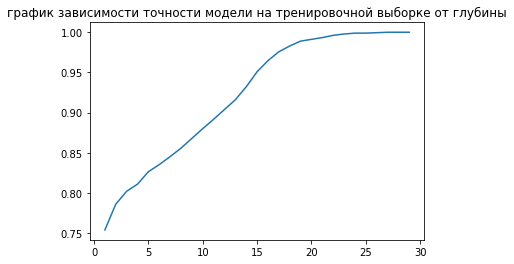

In [83]:
best_model = None
best_result = 0
best_depth = 0
result_for_plot = []
depth_for_plot = []

for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    result = model.score(features_train,target_train) # посчитайте качество модели на валидационной выборке
    result_for_plot.append(result)
    depth_for_plot.append(depth)
    if result > best_result:
        best_model = model # сохраняем наилучшую модель
        best_result = result #  сохраняем наилучшее значение метрики accuracy на валидационных данных
        best_depth = depth

print("Accuracy наилучшей модели на тренировочной выборке:", best_result,  "Максимальная глубина:", best_depth)
plt.plot(depth_for_plot, result_for_plot)
plt.title('график зависимости точности модели на тренировочной выборке от глубины')
plt.show()

Accuracy наилучшей модели на валидационной выборке: 0.8109452736318408 Максимальная глубина: 8


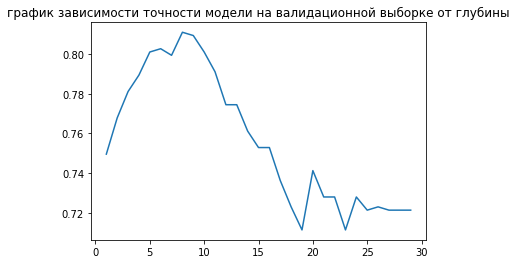

In [84]:
best_model = None
best_result = 0
best_depth = 0
result_for_plot = []
depth_for_plot = []

for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    result = model.score(features_valid,target_valid) # посчитайте качество модели на валидационной выборке
    result_for_plot.append(result)
    depth_for_plot.append(depth)
    if result > best_result:
        best_model = model # сохраняем наилучшую модель
        best_result = result #  сохраняем наилучшее значение метрики accuracy на валидационных данных
        best_depth = depth

print("Accuracy наилучшей модели на валидационной выборке:", best_result,  "Максимальная глубина:", best_depth)
plt.plot(depth_for_plot, result_for_plot)
plt.title('график зависимости точности модели на валидационной выборке от глубины')
plt.show()

Accuracy наилучшей модели на тренировочной и валидационной выборках: 1.0 Максимальная глубина: 23


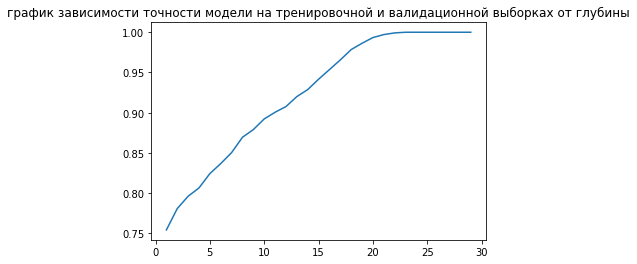

In [85]:
best_model = None
best_result = 0
best_depth = 0
result_for_plot = []
depth_for_plot = []

for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features, target)
    result = model.score(features,target) # посчитайте качество модели на валидационной выборке
    result_for_plot.append(result)
    depth_for_plot.append(depth)
    if result > best_result:
        best_model = model # сохраняем наилучшую модель
        best_result = result #  сохраняем наилучшее значение метрики accuracy на валидационных данных
        best_depth = depth

print("Accuracy наилучшей модели на тренировочной и валидационной выборках:", best_result,  "Максимальная глубина:", best_depth)
plt.plot(depth_for_plot, result_for_plot)
plt.title('график зависимости точности модели на тренировочной и валидационной выборках от глубины')
plt.show()

## Классификация методом случайного леса с разными значениями гиперпараметров

In [86]:
best_model_2 = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(1, 51, 1):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # обучаем модель с заданным количеством деревьев
        model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
        result = model.score(features_train,target_train) # посчитайте качество модели на тренировочной выборке
        if result > best_result:
            best_model_2 = model # сохраняем наилучшую модель
            best_result = result #  сохраняем наилучшее значение метрики accuracy на трениовочных данных
            best_est = est
            best_depth = depth

print("Accuracy наилучшей модели на тренировочной выборке:", best_result, "Количество деревьев:", best_est, "Глубина:", best_depth)

Accuracy наилучшей модели на тренировочной выборке: 0.8970669618151632 Количество деревьев: 50 Глубина: 10


In [87]:
#%%time 

#for n_estimators in tqdm(range(3,58)):
best_model_2 = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(1, 51, 1):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # обучаем модель с заданным количеством деревьев
        model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
        result = model.score(features_valid,target_valid) # посчитайте качество модели на валидационной выборке
        if result > best_result:
            best_model_2 = model # сохраняем наилучшую модель
            best_result = result #  сохраняем наилучшее значение метрики accuracy на валидационных данных
            best_est = est
            best_depth = depth

print("Accuracy наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Глубина:", best_depth)

Accuracy наилучшей модели на валидационной выборке: 0.8076285240464345 Количество деревьев: 11 Глубина: 10


In [88]:
best_model_2 = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(1, 51, 1):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # обучаем модель с заданным количеством деревьев
        model.fit(features, target) # обучаем модель на тренировочной выборке
        result = model.score(features,target) # посчитайте качество модели на тренировочной выборке
        if result > best_result:
            best_model_2 = model # сохраняем наилучшую модель
            best_result = result #  сохраняем наилучшее значение метрики accuracy на трениовочных данных
            best_est = est
            best_depth = depth

print("Accuracy наилучшей модели на тренировочной и валидационной выборках:", best_result, "Количество деревьев:", best_est, "Глубина:", best_depth)

Accuracy наилучшей модели на тренировочной и валидационной выборках: 0.8946058091286307 Количество деревьев: 50 Глубина: 10


## Логистическая регрессия

In [92]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=100)

model.fit(features_train, target_train)

result = model.score(features_train,target_train)

print("Accuracy модели на тренировочной выборке:", result)

Accuracy модели на тренировочной выборке: 0.746541228555617


In [93]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=100)

model.fit(features_train, target_train)

result = model.score(features_valid,target_valid)

print("Accuracy модели на валидационной выборке:", result)

Accuracy модели на валидационной выборке: 0.7495854063018242


In [94]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=100)

model.fit(features, target)

result = model.score(features,target)

print("Accuracy модели на тренировочной и валидационной выборках:", result)

Accuracy модели на тренировочной и валидационной выборках: 0.7481327800829876


## Проверка модели на тестовой выборке

Будем использовать классификацию методом случайного леса с 50 деревьями и глубиной 10, 

Accuracy наилучшей модели на тренировочной и валидационной выборках: 0.8946058091286307 Количество деревьев: 50 Глубина: 10

In [95]:
target_test = target_test.tolist()

model = RandomForestClassifier(random_state=12345, n_estimators=11, max_depth=10) #20 9
model.fit(features_train, target_train)
test_predictions = model.predict(features_test)



def error_count(answers, predictions):
    errors = 0
    for i in range(len(answers)):
        if predictions[i] != answers[i]:
            errors += 1
    return errors

print("Ошибок:", error_count(target_test, test_predictions))


accuracy = accuracy_score(target_test, test_predictions)
print('accuracy:',accuracy)

#найдем матрицу 
r = sklearn.metrics.confusion_matrix(target_test, test_predictions)
r = numpy.flip(r) #перевернём матрицу
print(r)




Ошибок: 165
accuracy: 0.7947761194029851
[[120 126]
 [ 39 519]]


True Positive = 120
True Negative = 519
False Negative = 126
False Positive = 39

Стоит учесть, что метрика accuracy может быть обманчивой. Один из таких случаев — это несбалансированные данные.


Precision представляет собой отношение числа семплов, верно классифицированных как Positive, к общему числу выборок с меткой Positive (распознанных правильно и неправильно). Precision измеряет точность модели при определении класса Positive.

Recall рассчитывается как отношение числа Positive выборок, корректно классифицированных как Positive, к общему количеству Positive семплов. Recall измеряет способность модели обнаруживать выборки, относящиеся к классу Positive. Чем выше recall, тем больше Positive семплов было найдено.

Теперь то же самое, но модель обучим на валидационной и тренировочной выборках

In [96]:


model = RandomForestClassifier(random_state=12345, n_estimators=50, max_depth=10) #20 9
model.fit(features, target)
test_predictions = model.predict(features_test)



def error_count(answers, predictions):
    errors = 0
    for i in range(len(answers)):
        if predictions[i] != answers[i]:
            errors += 1
    return errors

print("Ошибок:", error_count(target_test, test_predictions))


accuracy = accuracy_score(target_test, test_predictions)
print('accuracy:',accuracy)

#найдем матрицу 
r = sklearn.metrics.confusion_matrix(target_test, test_predictions)
r = numpy.flip(r) #перевернём матрицу
print(r)

Ошибок: 151
accuracy: 0.8121890547263682
[[132 114]
 [ 37 521]]


In [98]:
report = classification_report(target_test, test_predictions, target_names=['Smart', 'Ultra'])
print(report)

              precision    recall  f1-score   support

       Smart       0.82      0.93      0.87       558
       Ultra       0.78      0.54      0.64       246

    accuracy                           0.81       804
   macro avg       0.80      0.74      0.75       804
weighted avg       0.81      0.81      0.80       804



In [99]:
precision = sklearn.metrics.precision_score(target_test, test_predictions, pos_label=1)
print('precision Ultra:',precision)

precision = sklearn.metrics.precision_score(target_test, test_predictions, pos_label=0)
print('precision Smart:',precision)

recall = sklearn.metrics.recall_score(target_test, test_predictions, pos_label=1)
print('recall Ultra:',recall)

recall = sklearn.metrics.recall_score(target_test, test_predictions, pos_label=0)
print('recall Smart:',recall)

precision Ultra: 0.7810650887573964
precision Smart: 0.8204724409448819
recall Ultra: 0.5365853658536586
recall Smart: 0.9336917562724014


## Выводы

В данной работе удалось найти удачную и наиболее точную модель для анализа тарифов сети Мегалайн. Таким методом оказался случайный лес с количеством деревьев 11 и глубиной 10. Проверка на тестовой выборке показала значение точности 0.82, когда на тренировочной + валидационной выборке значение было 0.89. Надо сказать, что данные неравномерны. Данных по тарифу Ультра меньше, поэтому по другим метрикам можно оценить, что модель хуже определяет этот тариф. Метрика F1  для Ультра всего 0.64, когда для Смарта она 0.87.

In [2]:
from IPython.display import HTML


def print_hr_line():
    display(HTML('<hr align="left" width="500" size="4" color="#dddddd" />'))


# Добавляем новые стили в проект
style = """<style>
div.red_line {height:30px; width:560px; border-left:2px solid #cc0030; padding-left:10px;}
div.blue_line {height:30px; width:560px; border-left:7px solid #0A58E5; padding-left:10px;}
div.text_comment {font-family: verdana;font-size: 100%;background-color: #C7D5EE;border-color: black;border-style: solid;padding: 5px}
div.text_comment_student {font-family: verdana;font-size: 100%;background-color: #32C462;border-color: black;border-style: solid;padding: 5px}

div.text_comment_new_year {

   text-transform: uppercase;
  background-image: linear-gradient(
    -225deg,
    #231557 0%,
    #44107a 29%,
    #AEC226 50%,
    #ff1361 67%,
    #fff800 100%
  );
  background-size: auto auto;
  background-clip: border-box;
  background-size: 200% auto;
  color: #fff;
  background-clip: text;
  text-fill-color: transparent;
  -webkit-background-clip: text;
  -webkit-text-fill-color: transparent;
  animation: textclip 2s linear infinite;
  display: inline-block;
      font-size: 15px;
}

@keyframes textclip {
  to {
    background-position: 100% center;
  }
}
</style>"""
HTML(style)